In [2]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, "../src")

Let's try to apply the DLT again, but this time with some normalization.

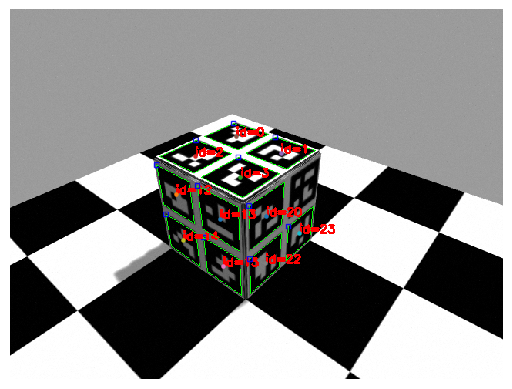

array([20, 12,  3,  2,  1,  0, 15, 22, 14, 23, 13], dtype=int32)

In [4]:
import cv2 as cv
import matplotlib.pyplot as plt
import tempfile
from pathlib import Path
import numpy as np

from camera import (
    move_camera_pos,
    get_camera_image_rgb,
    get_camera_image_depth,
    draw_aruco_grid,
    extract_aruco_tags,
    draw_aruco_tags,
    map_id_to_world_coords,
)
import rospy

rospy.init_node("camera_test")
move_camera_pos(-0.4, -0.4, 1, pitch=0.6, yaw=0.7)
rgb = get_camera_image_rgb()
frame_markers, corners, ids = extract_aruco_tags(rgb)
draw_aruco_tags(frame_markers, corners, ids)
plt.show()
ids = ids.reshape(-1)
ids

- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:bali_3d_reconstruction_using_dlt.pdf
- https://pvela.gatech.edu/classes/lib/exe/fetch.php?media=ece4580:ece4580_t03_calibration.pdf
- https://rpg.ifi.uzh.ch/docs/teaching/2020/03_camera_calibration.pdf

In [27]:
from camera import compute_dlt

mapping = map_id_to_world_coords(border=10, width=175, total=400, side_length=0.1)
corner_means = np.array(corners).squeeze(1).mean(axis=1)
P = compute_dlt(mapping[ids], corner_means)
P

array([[-7.92507305e+02, -1.33840904e+02, -2.12259136e+03,
         3.34105995e+02],
       [-2.10101983e+02, -2.92277614e+02, -2.66905397e+03,
         3.38092423e+02],
       [-9.39876783e-01, -8.82854149e-01, -6.03399324e+00,
         1.00000000e+00]])

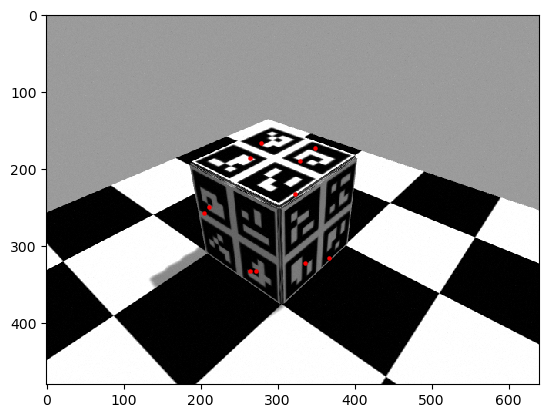

In [28]:
# let's reproject the points and see if they are close to the original ones
Z = P @ np.vstack([mapping[ids].T, np.ones(len(ids))])
Z = Z / Z[2]
Z = Z.T
plt.imshow(rgb)
plt.scatter(Z[:, 0], Z[:, 1], c="r", s=5)
plt.show()